#  Exercices supplémentaires



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABNLP%2005_exo_supp%C2%BB&security.allowlist.enabled=false)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=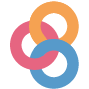)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/NLP/05_exo_supp.ipynb)

Cette page approfondit certains aspects présentés dans les autres tutoriels. Il s'agit d'une suite d'exercice, avec corrections, pour présenter d'autres aspects du NLP ou pratiquer sur des données différentes

# Exploration des libellés de l'openfood database

L'objectif de cet exercice est d'analyser les termes les plus fréquents
dans les noms de produits de l'openfood database. Au passage, cela permet de réviser les étapes de *preprocessing* (LIEN XXXXX) et d'explorer les enjeux de reconnaissance d'entités nommées. 

Dans cet exercice:

* tokenisation (`nltk`)
* retrait des stop words (`nltk`)
* nuage de mots (`wordcloud`)
* reconnaissance du langage (`fasttext`)
* reconnaissance d'entités nommées (`spacy`)

le tout sur l'OpenFood Database, une base de données alimentaire qui est enrichie de manière collaborative. 

Pour pouvoir utiliser les modèles pré-entraînés de `spaCy`, il faut les télécharger. La méthode préconisée est d'utiliser, depuis un terminal, la commande suivante

In [ ]:
python -m spacy download fr_core_news_sm

Dans un notebook jupyter, il se peut qu'il soit nécessaire de relancer le kernel.

Si l'accès à la ligne de commande n'est pas possible, ou si la commande échoue, il est possible de télécharger le modèle pré-entraîné directement depuis une session `Python`

In [ ]:
import spacy
spacy.cli.download('fr_core_news_sm')

1. Importer le modèle de reconnaissance de langage qui sera utilisé par la suite
ainsi que le corpus Français utilisé par `spacy`



2. Importer les données de l'[openfood database](https://fr.openfoodfacts.org/data) à partir du code suivant


In [ ]:
import pandas as pd
import urllib.request


urllib.request.urlretrieve('https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv', "%s.openfood.csv" % temp_dir)

```
## ('/tmp/tmp2bkp6se9.openfood.csv', <http.client.HTTPMessage object at 0x7feb4c58fa30>)
```

In [ ]:
df_openfood = pd.read_csv("%s.openfood.csv" % temp_dir, delimiter="\t",
                          usecols=['product_name'], encoding = 'utf-8', dtype = "str")

Ces données devraient avoir l'aspect suivant:

```
##      product_name
## 0  jeunes pousses
## 1         L.casei
```

3. Créer une fonction de nettoyage des noms de produits effectuant les 
étapes suivantes:

* tokeniser le texte en question
* retirer la ponctuation et les _stopwords_

Appliquer cette fonction à l'ensemble des noms de produits (variable
`product_name`)


4. Effectuer un nuage de mot sur les libellés avant et après nettoyage
pour comprendre la structure du corpus en question.
Le résultat devrait avoir l'apparence suivante


In [ ]:
import wordcloud as wc
import matplotlib.pyplot as plt


def graph_wordcloud(data, by = None, valueby = None, yvar = "Text"):
    if (by is not None) & (valueby is not None):        
        txt = data[data[by]==valueby][yvar].astype(str)
    else:
        txt = data[yvar].astype(str)
    all_text = ' '.join([text for text in txt])
    wordcloud = wc.WordCloud(width=800, height=500,
                          random_state=21,
                      max_words=2000).generate(all_text)
    return wordcloud

def graph_wordcloud_by(data, by, yvar = "Text"):
    n_topics = data[by].unique().tolist()
    width=20
    height=80
    rows = len(n_topics)//2
    cols = 2
    fig=plt.figure(figsize=(width, height))
    axes = []
    for i in range(cols*rows):
        b = graph_wordcloud(data, by = by, valueby = n_topics[i], yvar = yvar)
        axes.append( fig.add_subplot(rows, cols, i+1) )
        axes[-1].set_title("{}".format(n_topics[i]))  
        plt.imshow(b)
        plt.axis('off')
        plt.savefig('{}.png'.format(yvar), bbox_inches='tight')


def wordcount_words(data, yvar, by = None):
    plt.figure( figsize=(15,15) )
    if by is None:
        wordcloud = graph_wordcloud(data, yvar = yvar, by = by)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.savefig('{}.png'.format(yvar), bbox_inches='tight')
    else:
        graph_wordcloud_by(data, by = by, yvar = yvar)

wordcount_words(df_openfood, yvar = "product_name")
wordcount_words(df_openfood, "tokenized")

```r
knitr::include_graphics("product_name.png")
```


```r
knitr::include_graphics("tokenized.png")
```

5. Utiliser la librairie `fasttext` pour extraire les noms de produits
français

* Appliquer le modèle téléchargé précedemment pour déterminer le langage
* Ne récupérer que les libellés français


In [ ]:
import fasttext

PRETRAINED_MODEL_PATH = "%s.model.bin" % temp_dir
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

```
## Warning : `load_model` does not return WordVectorModel or SupervisedModel any more, but a `FastText` object which is very similar.
```

In [ ]:
newcols = ['language','score_language']
df_openfood[newcols] = pd.DataFrame(df_openfood['product_name'].astype(str).apply(lambda s: list(model.predict(s))).apply(lambda l: [l[0][0],l[1][0]]).tolist(), columns = newcols)
df_openfood['language'] = df_openfood['language'].str.replace("__label__","")
df_openfood_french = df_openfood[df_openfood['language'] == "fr"]
df_openfood_french.head(2)

```
##                    product_name             tokenized language  score_language
## 0                jeunes pousses        jeunes pousses       fr        0.971347
## 7   moutarde au moût de raisin   moutarde moût raisin       fr        0.990018
```

6. Visualiser avec `spacy.displacy` le résultat d'une reconnaissance
d'entités nommées sur 50 données aléatoires. Cela vous semble-t-il satisfaisant ?


In [ ]:
import spacy
import fr_core_news_sm

nlp = fr_core_news_sm.load()

example = " \n ".join(df_openfood_french['product_name'].astype("str").sample(50))

from spacy import displacy
html = displacy.render(nlp(example), style='ent', page=True)

```r
cat(py$html)
```

<!DOCTYPE html>
<html lang="fr">
    <head>
        <title>displaCy</title>
    </head>

    <body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol'; padding: 4rem 2rem; direction: ltr">
<figure style="margin-bottom: 6rem">
<div class="entities" style="line-height: 2.5; direction: ltr">
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Mousse
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 de canard </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Escalope
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 milanaise de poulet pané aux poivres </br> Filet mignon de porc 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Label rouge Bleu blanc
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 coeur </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Amandes
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 décortiquées </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Touche de Thé Saveur
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 citron </br> Concassé de baobab </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Boisson
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 instantanée </br> Sorbet plein fruit citron vert </br> Saucisse de Francfort </br> Sirop de 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    grenadine 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
Saucisson sec de l'île de beauté </br> Poitrine de poulet fumé </br> 6 merguez de porc </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Terrine de canard
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Mini
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 poulet cordon bleu </br> Melange sportif </br> Thé vert à la fraise </br> Crème d'artichaut et truffe d'été </br> Coulis de 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Framboise 
 Steak
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 de cuisse de poulet </br> COURONNE 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    BRETZEL 250G 
 Soupe
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 de poissons aux étrilles </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Petites
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 gambas compotée de tomates 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Tagliatelles
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 au pesto </br> Figues au foie gras mi-cuit </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Bruge cubes 
 Jambon
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 périgourdin </br> Saucisse sèche au piment d'espelette </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Cabillaud Panés Qualité
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 100% 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Filet MSC 
 2 Bavettes
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 d'
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Aloyau 
 Poulet
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 aux noix de cajou </br> Croissant </br> Compote pomme mangue </br> Pâte à tartiner aux noisettes du 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Piémont
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 42% </br> Sirop d'agave </br> Glace framboise fleur de sureau </br> 1 faux filet </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Cèpenade
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
 nature </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Fromage Blanc
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 1/2 écrémé 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    BBC
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 500g </br> Aguardiente de orujo de liebana </br> Poulet fermier </br> Pain au chocolat au beurre </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Comté 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
Melande deboulette </br> Pâtes alimentaires de blé dur biologique </br> Confit de canard </br> 
<mark class="entity" style="background: #ff9561; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Escalope
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">LOC</span>
</mark>
 cordon bleu poulet </br> 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Croquettes 
 Cassoulet
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">MISC</span>
</mark>
 au confit de canard </br> Goût 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Myrtille 
 
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">PER</span>
</mark>
Mélange mexicain</div>
</figure>
</body>
</html>

7. Récupérer dans un vecteur les entités nommées reconnues par `spaCy`.
Regarder les entités reconnues dans les 20 premiers libellés de produits 


In [ ]:
x = []
for doc in nlp.pipe(df_openfood_french.head(20)['product_name'].astype("unicode"), disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
    # Do something with the doc here
    x.append([(ent.text, ent.label_) for ent in doc.ents])
    
x

```
## [[], [], [('Pistou', 'PER')], [], [], [('Sachet calisson', 'PER')], [], [], [], [], [('Vainilla', 'PER')], [], [('Solène', 'PER')], [], [('Caramel', 'ORG')], [], [('Chouquettes x', 'MISC')], [('maïs bio', 'PER')], [], [('Bouillie', 'MISC')]]
```

<!----
# State of the union address

Un exercice à venir sur l'analyse des discours des présidents américains 
inspiré de https://github.com/BuzzFeedNews/2018-01-trump-state-of-the-union
---->